# Prognositc (trajectory prediction) performance of baseline ML models on ADNI2 longitudinal data

* **Objectives:** 
    1. Predict Trajectory classes based on structural features
    2. Predict Trajectory classes based on structural features + baseline clinical score + demographics


* **Input modalities:**
    1. Coritcal thickness (CT)
    2. Hippocampal subfield volumes (HC) 


* **Models:**
    1. Logistic regression (Lasso)
    2. SVM
    3. Random Forest
    
    
* **Code organization:**
    1. Stage 1: 
        1. Import raw data, and setup CV folds based on choice of input features 
        2. Save this experimental setup to disk
        
    2. Stage 2:
        1. Train and test ML models over k-fold setup (Parallelized implmentation)
        2. Plot and save performance results 

In [15]:
# Basic Imports
import numpy as np
import pandas as pd
from scipy import stats
import pickle
import re
import collections
import tables as tb
from math import isnan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold

%matplotlib inline
#plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

In [3]:
# Some Defs
def load_data(data_path, input_node, preproc):
    data = tb.open_file(data_path, 'r')
    X_raw = data.get_node('/' + input_node)[:]
    if preproc == 'scale':
        X = preprocessing.scale(X_raw)
    elif preproc == 'norm_max':
        X = preprocessing.normalize(X_raw, norm='max')
    elif preproc == 'norm_l2':
        X = preprocessing.normalize(X_raw, norm='l2')
    else:
        X = X_raw
    data.close()
    return X

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

#Outer Fold Computation (need the imports inside def if you want to parallelize!)
def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, output_type, model_type):    
    import collections
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    import datetime
    import time
    import collections
    from scipy.stats import mode
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from scipy import stats
    import numpy as np
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    inner_loop = True
    if inner_loop:     
        print 'Starting InnerFold computation'        
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
    
    if output_type == 'regression':
        #CV_scores    
        r_train = stats.pearsonr(clf.predict(train_X),train_y)
        r_valid = stats.pearsonr(clf.predict(valid_X),valid_y)

        R2_train = clf.score(train_X,train_y) 
        R2_valid = clf.score(valid_X,valid_y)

        MSE_train = mse(clf.predict(train_X),train_y)
        MSE_valid = mse(clf.predict(valid_X),valid_y)

        MAE_train = mae(clf.predict(train_X),train_y)
        MAE_valid = mae(clf.predict(valid_X),valid_y)
        
        return_dict = {'r_train':r_train, 'r_valid':r_valid, 'R2_train':R2_train, 'R2_valid':R2_valid,
            'MSE_train':MSE_train, 'MSE_valid':MSE_valid, 'MAE_train':MAE_train, 'MAE_valid':MAE_valid,
            'hp_dict':hp_dict, 'predicted_fold_score': clf.predict(valid_X), 'actual_fold_scores':valid_y}
        
    elif output_type == 'classify':
        pred_y = clf.predict(valid_X) #Specific label value
        pred_y_prob = clf.predict_proba(valid_X) #Label probabilty (used for ROC)

        #feature imp (issue with the innerCVLoop)
        if model_type == 'RFC':
            feat_imp = clf.best_estimator_.feature_importances_
        elif model_type == 'LR_L1':
            feat_imp = clf.best_estimator_.coef_ 
        else: 
            print "Unknown model for computing feature importance. Setting it to zeros"
            feat_imp = np.zeros(len(pred_y))

        print 'Ending OuterFold computation'

        return_dict = {'actual_fold_scores':valid_y, 'predicted_fold_prob':pred_y_prob, 'predicted_fold_score': pred_y, 
                'hp_dict':hp_dict, 'feat_imp': feat_imp}
    
    else: 
        print 'unknown output_type'

    print 'Ending OuterFold computation'
    
    return return_dict

#Inner Fold Computation (need the imports inside def if you want to parallelize!)
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)   
    return clf

def autolabel(rects,_ax):
    for rect in rects:
        height = rect.get_height()
        _ax.text(rect.get_x() + rect.get_width()/2., 1.1*height,
                '{:03.2f}'.format(height),
                ha='center',            # vertical alignment
                va='bottom',             # horizontal alignment
                fontsize = 35)

## Stage 1

In [4]:
# Data imports
my_name = 'Traj_Exp6_MCI_demograph'
cohort = 'ADNI2'
clinical_scale = 'ADAS13'
exp_name = '{}_{}_{}'.format(my_name,cohort,clinical_scale)

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/'
#in_data_file = 'input_csv/Longitduinal_HC_CT_data.csv'
in_data_file = 'input_csv/Longitduinal_HC_CT_data_MCI_traj.csv'
in_data = pd.read_csv(baseline_dir + in_data_file)

In [23]:
# features / variables
clinical_scale = ['ADAS13']
hc_feat = ['L_CA1','L_subiculum','L_CA4DG','L_CA2CA3','L_stratum','L_Alv','L_Fimb','L_Fornix','L_Mam',
                 'R_CA1','R_subiculum','R_CA4DG','R_CA2CA3','R_stratum','R_Alv','R_Fimb','R_Fornix','R_Mam']
ct_feat = ['AAL_1', 'AAL_2', 'AAL_3','AAL_4', 'AAL_5', 'AAL_6', 'AAL_7', 'AAL_8', 'AAL_9', 'AAL_10',
                 'AAL_11', 'AAL_12', 'AAL_13', 'AAL_14', 'AAL_15', 'AAL_16', 'AAL_17', 'AAL_18', 'AAL_19', 'AAL_20', 
                 'AAL_21', 'AAL_22', 'AAL_23', 'AAL_24', 'AAL_25', 'AAL_26', 'AAL_27', 'AAL_28', 'AAL_29', 'AAL_30', 
                 'AAL_31', 'AAL_32', 'AAL_33', 'AAL_34', 'AAL_35', 'AAL_36', 'AAL_39', 'AAL_40', 'AAL_43', 'AAL_44', 
                 'AAL_45', 'AAL_46', 'AAL_47', 'AAL_48', 'AAL_49', 'AAL_50', 'AAL_51', 'AAL_52', 'AAL_53', 'AAL_54',
                 'AAL_55', 'AAL_56', 'AAL_57', 'AAL_58', 'AAL_59', 'AAL_60', 'AAL_61', 'AAL_62', 'AAL_63', 'AAL_64', 
                 'AAL_65', 'AAL_66', 'AAL_67', 'AAL_68', 'AAL_69', 'AAL_70', 'AAL_79', 'AAL_80', 'AAL_81', 'AAL_82',
                 'AAL_83', 'AAL_84', 'AAL_85', 'AAL_86', 'AAL_87', 'AAL_88', 'AAL_89', 'AAL_90']


# Pick input features (modalities)
mr_feat = hc_feat + ct_feat + clinical_scale

#Pick timepoints for input and output variables
timepoint_mr = '_bl'
timepoint_cs = '_bl'

feat=[]
for c, cs in enumerate(clinical_scale):
    clinical_scale[c] = cs + timepoint_cs
for m, mr in enumerate(mr_feat):
    feat.append(mr + timepoint_mr)

#additional timpoint for structural features (hc or ct)
timepoint_mr = '_m06'
for m, mr in enumerate(mr_feat):
    feat.append(mr + timepoint_mr)
    
#add demographics
# feat.append('AGE')
# feat.append('APOE4')


In [24]:
#Trajectory stats
traj_threshold = 'Traj'
X = np.array(in_data[feat])
y = np.squeeze(np.array(in_data[traj_threshold]))
#y_dx = np.squeeze(np.array(in_data[['DX_cat'+timepoint_mr]]))
y_dx = np.squeeze(np.array(in_data[traj_threshold]))

filtered_idx = np.isfinite(y)
y = y[filtered_idx]
y_dx = y_dx[filtered_idx]
X = X[filtered_idx,:]

print 'X shape:{}, y shape:{}, dx shape:{}'.format(X.shape, y.shape, y_dx.shape)
print '# of Class 1 subjects: {}:'.format(len(y[y==1]))

X shape:(156, 194), y shape:(156,), dx shape:(156,)
# of Class 1 subjects: 81:


In [25]:
# Create folds for CV (default Stratified based on DX)
save_experimental_setup = True #Saves X, y, and KF

n_folds = 10
KF_type = 'stratified' #baseline_dir + 'exp_data/CV_Exp6_ADNI1and2_ADAS13.pkl'  #'path/to/previous/setup' or 'stratified' or 'none'
if KF_type == 'none':
    print 'KFold'
    kf = KFold(len(y), n_folds=10)
elif KF_type == 'stratified': 
    print 'Stratified KFold'
    kf = StratifiedKFold(y_dx, n_folds=10)
else:
    print 'Loading previously saved KF from: {}'.format(KF_type)
    old_exp_setup = pickle.load( open(KF_type, "rb" ) )
    kf = old_exp_setup['kf']
    
for train_index, test_index in kf:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print 'DX distribution (AD,CN,LMCI): {}'.format((np.sum(y_dx[test_index]==0),np.sum(y_dx[test_index]==1),
                                              np.sum(y_dx[test_index]==2)))
    print 'y_train_mean: {}, y_test_mean: {}'.format(np.mean(y_train),np.mean(y_test))

common_keys = in_data[['ImageUID']] #Uniq image ids for mapping subjects

save_path = baseline_dir + 'exp_setup/CV_{}_ADNI2_ADAS13_MR_{}_CS_{}_traj_{}.pkl'.format(exp_name,timepoint_mr,timepoint_cs,traj_threshold)    
print 'Saving exp_setup to: {}'.format(save_path)
if save_experimental_setup:    
    exp_setup = {'X': X, 'y': y, 'y_dx': y_dx, 'kf':kf,'common_subs':common_keys,'exp_name':exp_name}    
    pickleIt(exp_setup, save_path)        

Stratified KFold
DX distribution (AD,CN,LMCI): (8, 9, 0)
y_train_mean: 0.517985611511, y_test_mean: 0.529411764706
DX distribution (AD,CN,LMCI): (8, 8, 0)
y_train_mean: 0.521428571429, y_test_mean: 0.5
DX distribution (AD,CN,LMCI): (8, 8, 0)
y_train_mean: 0.521428571429, y_test_mean: 0.5
DX distribution (AD,CN,LMCI): (8, 8, 0)
y_train_mean: 0.521428571429, y_test_mean: 0.5
DX distribution (AD,CN,LMCI): (8, 8, 0)
y_train_mean: 0.521428571429, y_test_mean: 0.5
DX distribution (AD,CN,LMCI): (7, 8, 0)
y_train_mean: 0.517730496454, y_test_mean: 0.533333333333
DX distribution (AD,CN,LMCI): (7, 8, 0)
y_train_mean: 0.517730496454, y_test_mean: 0.533333333333
DX distribution (AD,CN,LMCI): (7, 8, 0)
y_train_mean: 0.517730496454, y_test_mean: 0.533333333333
DX distribution (AD,CN,LMCI): (7, 8, 0)
y_train_mean: 0.517730496454, y_test_mean: 0.533333333333
DX distribution (AD,CN,LMCI): (7, 8, 0)
y_train_mean: 0.517730496454, y_test_mean: 0.533333333333
Saving exp_setup to: /projects/nikhil/ADNI_pred

In [11]:
# QC plots
qc_dict = {}
foldx = 0
idx = 0
for train_index, test_index in kf:        
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    for i in range(X_train.shape[1]): 
        if i < 18:
            modality = 'hc'
        else: 
            modality = 'ct'
            
        vol_mean_train = np.mean(X_train[:,i])
        corr_train = stats.pearsonr(X_train[:,i],y_train)[0]                
        qc_dict[idx]={'structure':mr_feat[i],'subset':'train','vol':vol_mean_train,'r':corr_train,'fold':foldx,'modality':modality}
        idx += 1
        
        vol_mean_test = np.mean(X_test[:,i])
        corr_test = stats.pearsonr(X_test[:,i],y_test)[0]        
        qc_dict[idx]={'structure':mr_feat[i],'subset':'test','vol':vol_mean_test,'r':corr_test,'fold':foldx,'modality':modality}
        idx += 1
    
    foldx += 1
    
qc_df = pd.DataFrame.from_dict(qc_dict,orient='index')
sns.set_context("notebook", font_scale=1)
sns.set_style("ticks")
modality = 'hc'
measure = 'r'
g = sns.factorplot(x='structure', y=measure, hue='subset', col='fold', col_wrap=2, data=qc_df[qc_df.modality==modality], size=5, kind='bar')

# Stage 2

In [5]:
# Configs for K-fold validations (nested)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse
from functools import partial #Parallelize!!! 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp
from sklearn.metrics import accuracy_score as acc
import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN #For treating class imbalance

In [6]:
#Pick model with its configs/hyper-paramsd
def getModel(model_choice,output_type): 
    if output_type == 'regression' :
        if model_choice == 'LR_L1':
            model_clf = Lasso()
            hyper_params = {'alpha':[0.1, 0.05, 0.01]} 
            scale_data = True #Scales HC and CT features    
            feat_imp = False   

        elif model_choice == 'SVR':
            model_clf = SVR()
            hyper_params = {'kernel':['linear','rbf'], 'C':[1,10,25]}
            scale_data = True #Scales HC and CT features        
            feat_imp = False

        elif model_choice == 'RFR':
            model_clf = RandomForestRegressor(n_jobs=4)
            hyper_params = {'n_estimators':[10,50,100,200],'min_samples_split':[2,4,8]}    
            scale_data = False    
            feat_imp = False   
        else:
            print "Unknown model choice"
    
    elif output_type =='classify':
        if model_choice == 'LR_L1':
            model_clf = LogisticRegression(penalty='l1',n_jobs=4,class_weight='balanced')
            hyper_params = {'C':[0.01,.1,1,10]} 
            scale_data = True #Scales features (z-score)            
            feat_imp = False #The learned weights of each variable

        elif model_choice == 'SVC':
            model_clf = SVC(class_weight='balanced',probability=True)
            hyper_params = {'kernel':['linear','rbf'], 'C':[1,10]}
            scale_data = True #Scales HC and CT features            
            feat_imp = False

        elif model_choice == 'RFC':    
            model_clf = RandomForestClassifier(n_jobs=4,class_weight='balanced' )
            hyper_params = {'n_estimators':[10,25,50],'min_samples_split':[2,4,8]}    
            scale_data = False            
            feat_imp = True   #RF oob based feature importance

        else:
            print "Unknown model choice"
    
    else: 
        print 'Unknown output type'

    return {'model_clf':model_clf,'hyper_params':hyper_params,'scale_data':scale_data,'feat_imp':feat_imp}

Modality: HC_CT_CS_long, model: LR_L1, X shape (156, 194)
most frequent hyper-params:{'C': array([ 0.1])}
CV Acc (mean, std_err): 0.64, 0.04
CV AUC (mean, std_err): 0.67, 0.05
CV Confusion Matrix (mean): [[ 0.62424603  0.37575397]
 [ 0.33279221  0.66720779]]

plotting :ROC


Modality: HC_CT_CS_long, model: SVC, X shape (156, 194)
most frequent hyper-params:{'kernel': array(['rbf'], 
      dtype='|S3'), 'C': array([10])}
CV Acc (mean, std_err): 0.64, 0.04
CV AUC (mean, std_err): 0.68, 0.04
CV Confusion Matrix (mean): [[ 0.64018038  0.35981962]
 [ 0.34722222  0.65277778]]

plotting :ROC


Modality: HC_CT_CS_long, model: RFC, X shape (156, 194)
most frequent hyper-params:{'n_estimators': array([50]), 'min_samples_split': array([2])}
CV Acc (mean, std_err): 0.63, 0.03
CV AUC (mean, std_err): 0.65, 0.04
CV Confusion Matrix (mean): [[ 0.61006494  0.38993506]
 [ 0.34611111  0.65388889]]

plotting :ROC




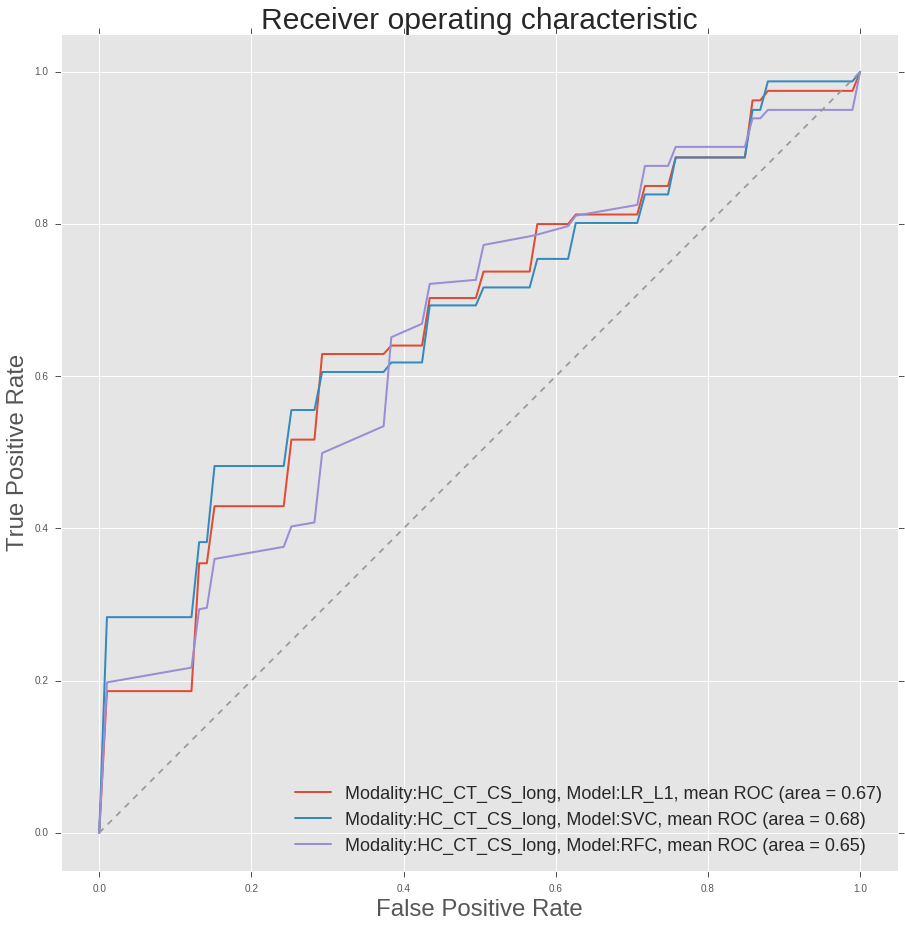

In [26]:
# Train and Test models
from functools import partial #Parallelize!!! 

# Load saved experimental setup
exp_name = 'Traj_Exp6_MCI_demograph'
Clinical_Scale = 'ADAS13'
timepoint_mr = 'm06'
timepoint_cs = 'bl'
traj_threshold = 'Traj'
resample_train_data = False
sampling_tech = 'smote'

exp_setup_path = baseline_dir + 'exp_setup/CV_{}_ADNI2_ADAS13_MR_{}_CS_{}_traj_{}.pkl'.format(exp_name,timepoint_mr,timepoint_cs,traj_threshold)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

# Parallization configs for ipython notebook cluster    
rc = ipp.Client()
dview = rc[:]
dview.push(dict(computeOuterFold = computeOuterFold))
dview.push(dict(innerCVLoop = innerCVLoop))

modalities = ['HC_CT_CS_long']
X_raw = exp_setup['X']
y = exp_setup['y']
kf = exp_setup['kf']
exp_name = exp_setup['exp_name']

output_type = 'classify' #needs to be either 'classify' or 'regression'
if output_type == 'regression':
    model_list = ['LR_L1', 'SVR', 'RFR']
elif output_type == 'classify':
    model_list = ['LR_L1', 'SVC', 'RFC']
else:
    print 'unknow output type'

save_CV_perf = False 
plt.rcParams['figure.figsize'] = (15,15)
long_offset = 97 #number of total features in each timepoint (18+78+1)
use_demograph = True
for modality in modalities:    
    if modality == 'HC_CT_CS_long':
        X_modality = X_raw[:,:2*long_offset]
    elif modality == 'HC_CT_CS':
        X_modality = X_raw[:,:long_offset]
    elif modality == 'HC_CT':
        X_modality = X_raw[:,:96]
    elif modality == 'HC_CS':
        X_modality = np.hstack((X_raw[:,:18],X_raw[:,96:long_offset]))
    elif modality == 'CT_CS':
        X_modality = X_raw[:,18:long_offset]
    elif modality == 'HC_CS_long':
        X_modality = np.hstack((X_raw[:,:18],X_raw[:,96:long_offset],X_raw[:,long_offset:long_offset+18],X_raw[:,long_offset+96:2*long_offset]))
    elif modality == 'CT_CS_long':
        X_modality = np.hstack((X_raw[:,18:97],X_raw[:,long_offset+18:long_offset+97]))
    elif modality == 'HC':
        X_modality = X_raw[:,:18]
    elif modality == 'CT':
        X_modality = X_raw[:,18:96]
    else:
        print "Wrong modality selected..."
        
    if use_demograph:
        X_modality = np.hstack((X_modality,X_raw[:,2*long_offset:]))

    ####################
    ## Select a model ##
    ####################       
    for model_choice in model_list:
        model_def = getModel(model_choice,output_type)
        model_clf = model_def['model_clf']
        hyper_params = model_def['hyper_params']
        scale_data = model_def['scale_data']    
        feat_imp = model_def['feat_imp']

        if scale_data:
            X = preprocessing.scale(X_modality)
        else:
            X = X_modality

        print 'Modality: {}, model: {}, X shape {}'.format(modality, model_choice, X.shape)
        #Some paths to store models and performance stats
        CV_model_dir = baseline_dir + 'output/'
        save_model_path = CV_model_dir + exp_name + '_' + model_choice + '_' + modality
        save_model = False 
        
        # Create list of all the fold-subsets (needed for parallelization)
        X_train = []
        X_valid = []
        y_train = []
        y_valid = []    
        for train, valid in kf:
            if resample_train_data:             
                #resample with tools from: https://github.com/scikit-learn-contrib/imbalanced-learn
                if sampling_tech == 'adasyn':                    
                    resamp_tech = ADASYN()
                elif sampling_tech == 'smote':
                    resamp_tech = SMOTE(kind='regular')
                else:
                    resamp_tech = RandomOverSampler()
                
                print 'using {} oversampling technique'.format(sampling_tech)                    
                X_resampled, y_resampled = resamp_tech.fit_sample(X[train], y[train])
                #print 'Original shapes: X{}, y:{}, y==1: {}'.format(X[train].shape, y[train].shape, np.sum(y[train]))
                #print 'Resampled shapes: X{}, y:{}, y==1: {}'.format(X_resampled.shape, y_resampled.shape, np.sum(y_resampled))                
                X_train.append(X_resampled)
                y_train.append(y_resampled)
            else:
                X_train.append(X[train])
                y_train.append(y[train])
            
            # No need to resample test data
            X_valid.append(X[valid])            
            y_valid.append(y[valid])

        # Compute various statistics on the predicted results acorss 10 Folds    
        if output_type == 'regression':
            CV_r_train=[] #pearson r score for each outer fold on train set
            CV_r_valid=[] #pearson r score for each outer fold on validation set
            CV_R2_train=[] #R2 score for each outer fold on train set
            CV_R2_valid=[] #R2 score for each outer fold on validation set
            CV_MSE_train=[] #MSE for each outer fold on train set
            CV_MSE_valid=[] #MSE for each outer fold on validation set    
            CV_MAE_train=[] #MSE for each outer fold on train set
            CV_MAE_valid=[] #MSE for each outer fold on validation set
        elif output_type == 'classify':        
            CV_Acc_valid=[] #Acuracy
            CV_CM_valid=[] #Confusion matrix
            CV_AUC_valid=[] #ROC and AUC       
            CV_fpr_tpr = []
            CV_fpr_tpr_thrsh = []
            CV_feat_imp = []
        else: 
            print 'unknown output type'

        predicted_CV_scores = []
        actual_CV_scores = []

        #Parallelize k-folds
        mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, output_type=output_type, model_type=model_choice)
        parallel_result = dview.map_sync(mapfunc, X_train, y_train, X_valid, y_valid)    

        hp_dict = collections.defaultdict(list)
        for pr in parallel_result:
            if output_type == 'regression':
                CV_r_train.append(pr['r_train'])
                CV_r_valid.append(pr['r_valid'])
                CV_R2_train.append(pr['R2_train'])
                CV_R2_valid.append(pr['R2_valid'])
                CV_MSE_train.append(pr['MSE_train'])
                CV_MSE_valid.append(pr['MSE_valid'])
                CV_MAE_train.append(pr['MAE_train'])
                CV_MAE_valid.append(pr['MAE_valid'])
                predicted_CV_scores.append(pr['predicted_fold_score'])
                actual_CV_scores.append(pr['actual_fold_scores'])                
                    
            elif output_type == 'classify':
                y_pred_score = pr['predicted_fold_score']
                y_pred_prob = pr['predicted_fold_prob']
                y_act = pr['actual_fold_scores']
                predicted_CV_scores.append(y_pred_score)
                actual_CV_scores.append(y_act)        

                #Acc    
                CV_Acc_valid.append(acc(y_pred_score,y_act))                

                #Roc - Auc
                fpr, tpr, thresholds = roc_curve(y_act, y_pred_prob[:,1]) 
                CV_fpr_tpr.append((fpr,tpr))        
                CV_fpr_tpr_thrsh.append(thresholds)
                CV_AUC_valid.append(roc_auc_score(y_act, y_pred_prob[:,1]))

                #confusion matrix
                cm = confusion_matrix(y_pred_score,y_act)
                cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
                CV_CM_valid.append(cm_normalized)

            for hp in hyper_params:
                hp_dict[hp].append(pr['hp_dict'][hp])
                
        #Find out most frequent hyper-params during cross-val    
        hp_mode = {}
        for hp in hyper_params:
            hp_mode[hp] = mode(hp_dict[hp])[0][0]

        if output_type == 'regression':
            print 'most frequent hp:' + str(hp_mode)
            print 'CV r (mean, median, std_err): ' + '{:04.2f},{:04.2f},{:04.2f}'.format(np.mean(zip(*CV_r_valid)[0]),np.median(zip(*CV_r_valid)[0]),stats.sem(zip(*CV_r_valid)[0]))
            print 'CV R2 (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_R2_valid),np.median(CV_R2_valid),stats.sem(CV_R2_valid))
            print 'CV MSE (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_MSE_valid),np.median(CV_MSE_valid),stats.sem(CV_MSE_valid))
            print 'CV MAE (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_MAE_valid),np.median(CV_MAE_valid),stats.sem(CV_MAE_valid))
            print ''
            
        elif output_type == 'classify':
            print 'most frequent hyper-params:' + str(hp_mode)
            print 'CV Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_valid),stats.sem(CV_Acc_valid))
            print 'CV AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_valid),stats.sem(CV_AUC_valid))
            print 'CV Confusion Matrix (mean): {}'.format(np.mean(np.array(CV_CM_valid),axis=0))
            print ''
            plot_name = 'ROC'
            
            print 'plotting :{}'.format(plot_name)
            print ''
            print ''
            mean_tpr = 0.0
            mean_fpr = np.linspace(0, 1, 100)
            all_tpr = []

            for i, (fpr, tpr) in enumerate(CV_fpr_tpr):                
                mean_tpr += interp(mean_fpr, fpr, tpr)
                mean_tpr[0] = 0.0
                roc_auc = auc(fpr, tpr)
                #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

            

            mean_tpr /= len(CV_fpr_tpr)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            plt.plot(mean_fpr, mean_tpr, label='Modality:{}, Model:{}, mean ROC (area = {:3.2f})'.format(modality, model_choice, mean_auc), lw=2)

            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.xlabel('False Positive Rate',fontsize = 24)
            plt.ylabel('True Positive Rate',fontsize = 24)
            plt.title('Receiver operating characteristic',fontsize = 30)
            plt.legend(loc="lower right",fontsize = 18)

        if save_CV_perf: 
            ts = time.time()
            st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')            
            save_model_path = CV_model_dir + exp_name + '_' + model_choice + '_' + modality + '_' + timepoint_mr + '_to_' + timepoint_cs + '_' + st + '.pkl'
            classifier_model_and_stats = {'best_clf_hyp':hp_mode, 'CV_R2':CV_R2_valid, 'CV_MSE':CV_MSE_valid,'CV_MAE':CV_MAE_valid, 'CV_r': CV_r_valid,
                                         'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
            pickleIt(classifier_model_and_stats,save_model_path)
            print 'saving results at: {}'.format(save_model_path)
            print ''

if output_type == 'classify':
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

In [ ]:
# Save models + CV perf
save_CV_perf = False    
if save_CV_perf:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    save_model_filename = save_model_path + '_' + modality + '_' + st + '.pkl'
    classifier_model_and_stats = {'best_clf':test_clf, 'CV_R2':CV_R2_valid, 'CV_MSE':CV_MSE_valid, 'CV_r': CV_r_valid,
                                 'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
    pickleIt(classifier_model_and_stats,save_model_filename)
    print 'saving results at: {}'.format(save_model_filename)
